In [1]:
#Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import re

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from wordcloud import WordCloud

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, precision_score
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn import svm, datasets
from sklearn.model_selection import GridSearchCV
from collections import Counter
from sklearn.preprocessing import OneHotEncoder,LabelEncoder,StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, \
                            f1_score, roc_auc_score, roc_curve, auc, \
                            precision_score, recall_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

import xgboost as xgb
from sklearn.ensemble import AdaBoostClassifier
!pip install catboost
from catboost import CatBoostClassifier, Pool, cv
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
import seaborn as sns
from sklearn.ensemble import BaggingClassifier
le = LabelEncoder()
enc = OneHotEncoder(handle_unknown='ignore') 
scalerstd = StandardScaler()

In [2]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [4]:
df = pd.read_csv("cyberbullying_tweets.csv")
df.head()

,tweet_text,cyberbullying_type
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying


In [5]:
df.describe()

,tweet_text,cyberbullying_type
count,47692,47692
unique,46017,6
top,RT @sailorhg: the intro for my hardware hackin...,religion
freq,2,7998


In [6]:
#Remove duplicates per row
df.drop_duplicates(inplace=True)
df.describe()

,tweet_text,cyberbullying_type
count,47656,47656
unique,46017,6
top,@sschinke @Blackamazon @shanley also sorta wor...,religion
freq,2,7997


In [7]:
pd.set_option('display.max_colwidth', None)
df_groupby_tweet=df.groupby('tweet_text').count().sort_values(by='cyberbullying_type', ascending=False).reset_index()
df_groupby_tweet[df_groupby_tweet['cyberbullying_type']>1]

,tweet_text,cyberbullying_type
0,What a riveting little lesson in walking the catwalk. Thanks ladies #MKR,2
1,"@KaitlynBurnell to be clear, i'm not bringing this up to defend bri. i'm aware that she's fully capable of defending herself.",2
2,@NedGilmore oh! go get meat from south.,2
3,@kate_1985 - not sure!! But never fear @mykitchenrules still has 751 teams left and another Instant Restaurant round to come. #MKR,2
4,@NetTxt doesn't work that way. Sorry to disappoint you. No one cares what you want.,2
...,...,...
1634,RT @HelpIamaCabbage: @freebsdgirl People are spending money to try to get you temporarily suspended from twitter? That may be the most was…,2
1635,TODO: email tax guy to ask if lavender bath bombs qualify as a business expense.,2
1636,"Yes, we get it. You're pretty. Tone down the self promo and just cook! @mykitchenrules #MKR",2
1637,"RT @DustyPee: If #cuntandandre make it through, I'll... I don't know what I will do. #mkr",2


In [8]:
df[df['tweet_text']=="Yes, we get it. You're pretty. Tone down the self promo and just cook! @mykitchenrules #MKR"]

,tweet_text,cyberbullying_type
9109,"Yes, we get it. You're pretty. Tone down the self promo and just cook! @mykitchenrules #MKR",gender
28463,"Yes, we get it. You're pretty. Tone down the self promo and just cook! @mykitchenrules #MKR",other_cyberbullying


In [9]:
#Remove duplicates based on tweet text. Keep only on cyberullying type per tweet
df.drop_duplicates(subset='tweet_text', keep="first", inplace=True)
df.describe()



,tweet_text,cyberbullying_type
count,46017,46017
unique,46017,6
top,"In other words #katandandre, your food was crapilicious! #mkr",religion
freq,1,7995


In [10]:
#Number of tweets per type of cyberbullying (after removing duplicates)
df.groupby('cyberbullying_type').count()

,tweet_text
cyberbullying_type,
age,7992
ethnicity,7952
gender,7898
not_cyberbullying,7937
other_cyberbullying,6243
religion,7995


In [11]:
stemmer = SnowballStemmer("english")
stemmer.stem("studies")

'studi'

In [12]:
lematizer=WordNetLemmatizer()
lematizer.lemmatize("studies")

'study'

In [13]:
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")
lematizer=WordNetLemmatizer()

def preprocess_tweet(tweet, stem=True):
    #Remove special caracters, links and user tags
    regexp_pattern="@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"
    tweet = re.sub(regexp_pattern, ' ', str(tweet).lower()).strip()
    #Remove stopwords
    tweet=" ".join([word for word in str(tweet).split() if word not in stop_words])
    #Stemming: Removes suffixes and prefixes. Ex. studies->studi.
    if stem==True:
        tweet= " ".join([stemmer.stem(word) for word in tweet.split()])
    #Lemmatizing: Gets the root word (better). studies->study
    tweet=" ".join([lematizer.lemmatize(word) for word in tweet.split()])
    return tweet

In [14]:
#Preprocess tweets
df['tweet_cleaned']=df['tweet_text'].apply(preprocess_tweet)
df.head()

,tweet_text,cyberbullying_type,tweet_cleaned
0,"In other words #katandandre, your food was crapilicious! #mkr",not_cyberbullying,word katandandr food crapilici mkr
1,Why is #aussietv so white? #MKR #theblock #ImACelebrityAU #today #sunrise #studio10 #Neighbours #WonderlandTen #etc,not_cyberbullying,aussietv white mkr theblock imacelebrityau today sunris studio10 neighbour wonderlandten etc
2,@XochitlSuckkks a classy whore? Or more red velvet cupcakes?,not_cyberbullying,classi whore red velvet cupcak
3,"@Jason_Gio meh. :P thanks for the heads up, but not too concerned about another angry dude on twitter.",not_cyberbullying,meh p thank head concern anoth angri dude twitter
4,"@RudhoeEnglish This is an ISIS account pretending to be a Kurdish account. Like Islam, it is all lies.",not_cyberbullying,isi account pretend kurdish account like islam lie


In [15]:
df.describe()

,tweet_text,cyberbullying_type,tweet_cleaned
count,46017,46017,46017
unique,46017,6,44918
top,"In other words #katandandre, your food was crapilicious! #mkr",religion,
freq,1,7995,271


In [16]:
df.groupby('tweet_cleaned').count().sort_values(by='cyberbullying_type', ascending=False).reset_index()

,tweet_cleaned,tweet_text,cyberbullying_type
0,,271,271
1,fuck dumb nigger,45,45
2,bulli,43,43
3,yes,25,25
4,feminazi,24,24
...,...,...,...
44913,halalflaw biebervalu come moron let go vers quran start 33 33 afraid,1,1
44914,halalflaw biebervalu greenlinerzjm bitch copi hadith go look hadith bitch,1,1
44915,halalflaw biebervalu greenlinerzjm go look word taquiyya,1,1
44916,halalflaw biebervalu greenlinerzjm islam cultur islam religion,1,1


In [17]:
#Remove empty tweets
df.dropna(subset = ["tweet_cleaned"], inplace=True)

In [18]:
df[df['tweet_cleaned']=='feminazi']
#Should be remove duplicates after cleaning tweet?

,tweet_text,cyberbullying_type,tweet_cleaned
8222,@piojaa_ feminazi,gender,feminazi
8503,@Bourgholtzer feminazi,gender,feminazi
9765,FEMINAZI,gender,feminazi
9791,'Feminazi' http://t.co/Y5skW0daNu,gender,feminazi
10138,@Fernandarova feminazi,gender,feminazi
11378,@FunkAd3 feminazi.,gender,feminazi
12134,To feminazi,gender,feminazi
12181,Feminazi (?),gender,feminazi
12385,Feminazi.,gender,feminazi
12817,Feminazi 😳,gender,feminazi


Type of cyberbullying: not_cyberbullying


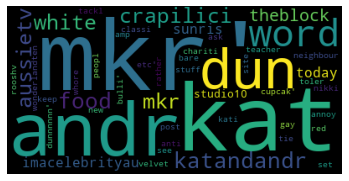


Type of cyberbullying: gender


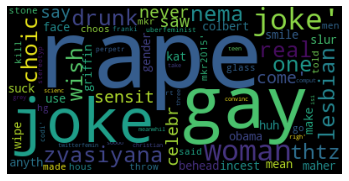


Type of cyberbullying: religion


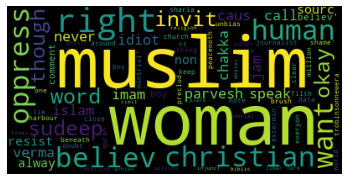


Type of cyberbullying: other_cyberbullying


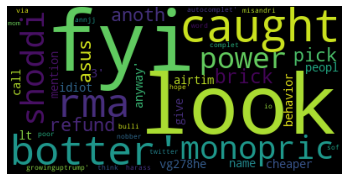


Type of cyberbullying: age


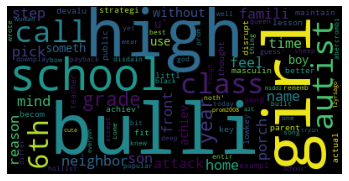


Type of cyberbullying: ethnicity


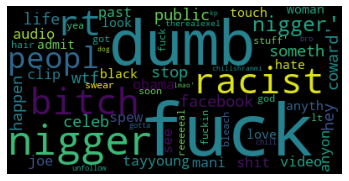

In [19]:
for i in df['cyberbullying_type'].unique():
  #Filter the tweets for each type
  tweets_type=df[df['cyberbullying_type']==i]
  tweets = tweets_type['tweet_cleaned'].values 
  #Generate wordcloud
  wordcloud = WordCloud().generate(str(tweets))
  print("Type of cyberbullying:", i)
  #Display word cloud
  plt.imshow(wordcloud)
  plt.axis("off")
  plt.show()
  print("")

Type of cyberbullying: not_cyberbullying
     word  count
0     mkr   1612
1   bulli   1231
2      rt    794
3    like    430
4     get    427
5      go    396
6  school    382
7     kat    300
8     amp    285
9   peopl    274


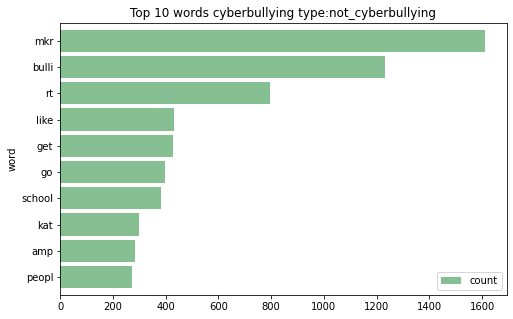


Type of cyberbullying: gender
    word  count
0   joke   5436
1   rape   4423
2    gay   4200
3   call   1411
4   make   1355
5     rt   1241
6  woman   1214
7  bitch   1181
8  femal   1134
9  peopl   1010


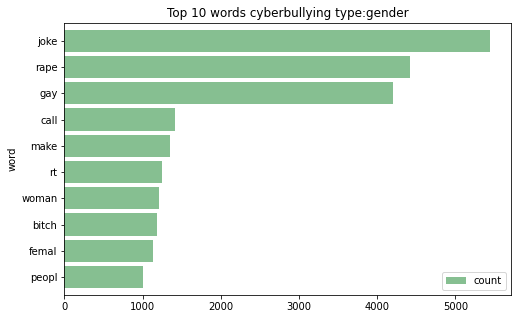


Type of cyberbullying: religion
        word  count
0     muslim   4868
1      idiot   3140
2      islam   2534
3  christian   2222
4          u   2030
5  terrorist   1468
6      right   1349
7       like   1283
8      woman   1279
9    support   1273


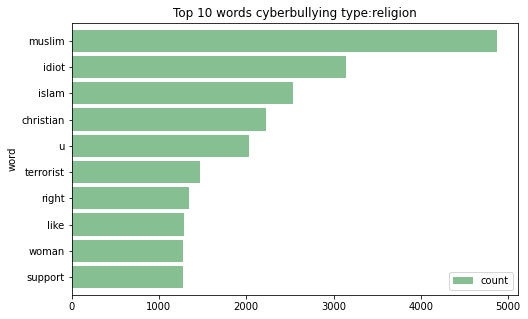


Type of cyberbullying: other_cyberbullying
    word  count
0  bulli    966
1     rt    750
2   fuck    520
3   like    429
4    get    394
5  peopl    354
6     go    279
7  idiot    272
8   know    247
9  think    241


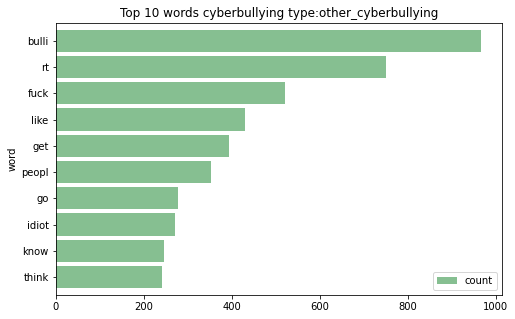


Type of cyberbullying: age
     word  count
0   bulli   9124
1  school   8658
2    high   5095
3    girl   4699
4    like   2094
5     get   1059
6     one   1052
7   peopl    936
8     got    827
9     kid    819


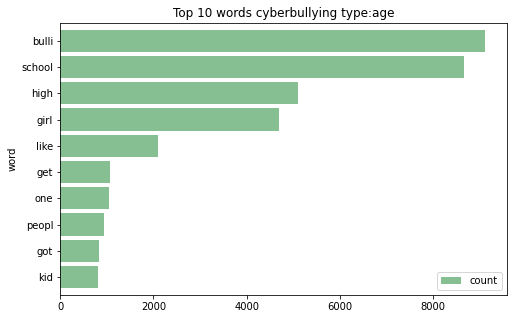


Type of cyberbullying: ethnicity
     word  count
0    fuck   6142
1  nigger   5799
2    dumb   5216
3      as   2303
4   black   2206
5       u   2167
6   white   1608
7    call   1393
8      rt   1221
9   peopl   1193


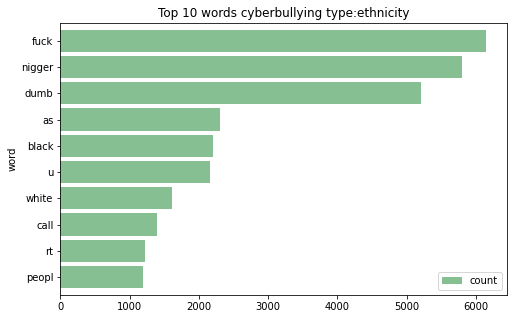

In [20]:
for i in df['cyberbullying_type'].unique():
  #Filter the tweets for each type
  tweets_type=df[df['cyberbullying_type']==i]
  tweets = tweets_type['tweet_cleaned'].values 
  print("Type of cyberbullying:", i)
  #Count frequency for each word and get top 10
  top_words=Counter(" ".join(df["tweet_cleaned"][df['cyberbullying_type']==i]).split()).most_common(10)
  top_words_df=pd.DataFrame(top_words, columns=['word', 'count'])
  print(top_words_df)
  top_words_df=top_words_df.sort_values('count',ascending=True)
  #Make horizontal bar plot to display top 10 words and their frequency
  top_words_df.plot.barh(x='word', y='count', figsize=(8, 5), title="Top 10 words cyberbullying type:"+i, color='#86bf91', zorder=2, width=0.85)
  plt.show()
  print("")

In [21]:
#Assign ids to each cyberbullying type
types=df['cyberbullying_type'].unique()
types_ids=[0,1,2,3,4,5]
df_cyber_types=pd.DataFrame(list(zip(types, types_ids)),
               columns =['cyberbullying_type', 'cyberbullying_id'])
df_cyber_types

,cyberbullying_type,cyberbullying_id
0,not_cyberbullying,0
1,gender,1
2,religion,2
3,other_cyberbullying,3
4,age,4
5,ethnicity,5


In [22]:
#Add cyberbullying ids to the full data
df=pd.merge(df, df_cyber_types, how='left', on='cyberbullying_type')
df.head()

,tweet_text,cyberbullying_type,tweet_cleaned,cyberbullying_id
0,"In other words #katandandre, your food was crapilicious! #mkr",not_cyberbullying,word katandandr food crapilici mkr,0
1,Why is #aussietv so white? #MKR #theblock #ImACelebrityAU #today #sunrise #studio10 #Neighbours #WonderlandTen #etc,not_cyberbullying,aussietv white mkr theblock imacelebrityau today sunris studio10 neighbour wonderlandten etc,0
2,@XochitlSuckkks a classy whore? Or more red velvet cupcakes?,not_cyberbullying,classi whore red velvet cupcak,0
3,"@Jason_Gio meh. :P thanks for the heads up, but not too concerned about another angry dude on twitter.",not_cyberbullying,meh p thank head concern anoth angri dude twitter,0
4,"@RudhoeEnglish This is an ISIS account pretending to be a Kurdish account. Like Islam, it is all lies.",not_cyberbullying,isi account pretend kurdish account like islam lie,0


In [23]:
#Get the length of the tweet: number of words
df['nwords']=(df['tweet_cleaned'].str.split()).apply(len)
#get number of letters
df['nletters']=(df['tweet_cleaned']).apply(len)
#get number of vowels
df['nvowels']=df['tweet_cleaned'].str.count(r'[aeiou]')
df.head()

,tweet_text,cyberbullying_type,tweet_cleaned,cyberbullying_id,nwords,nletters,nvowels
0,"In other words #katandandre, your food was crapilicious! #mkr",not_cyberbullying,word katandandr food crapilici mkr,0,5,34,10
1,Why is #aussietv so white? #MKR #theblock #ImACelebrityAU #today #sunrise #studio10 #Neighbours #WonderlandTen #etc,not_cyberbullying,aussietv white mkr theblock imacelebrityau today sunris studio10 neighbour wonderlandten etc,0,11,92,31
2,@XochitlSuckkks a classy whore? Or more red velvet cupcakes?,not_cyberbullying,classi whore red velvet cupcak,0,5,30,9
3,"@Jason_Gio meh. :P thanks for the heads up, but not too concerned about another angry dude on twitter.",not_cyberbullying,meh p thank head concern anoth angri dude twitter,0,9,49,14
4,"@RudhoeEnglish This is an ISIS account pretending to be a Kurdish account. Like Islam, it is all lies.",not_cyberbullying,isi account pretend kurdish account like islam lie,0,8,50,18


In [24]:
#Describe features for each cyberbullying type
df_features=df[['cyberbullying_type', 'nwords','nletters', 'nvowels']].groupby('cyberbullying_type').median().sort_values(by='nwords')
df_features

,nwords,nletters,nvowels
cyberbullying_type,,,
other_cyberbullying,7.0,42.0,13.0
not_cyberbullying,8.0,44.0,13.0
gender,12.0,72.0,22.0
ethnicity,14.0,77.0,22.0
age,16.0,94.0,29.0
religion,19.0,118.0,38.0


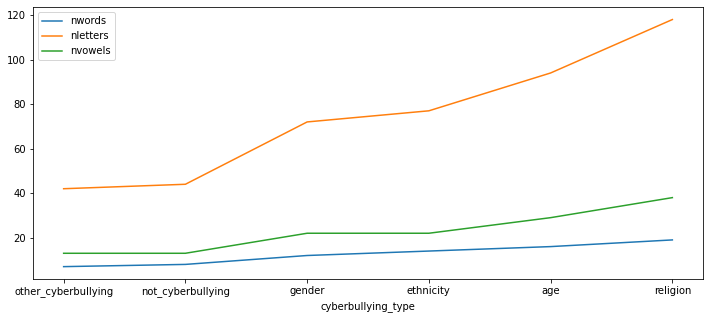

In [25]:
#Plot features
df_features.plot(figsize=(12, 5))

In [26]:
#Train/test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test, y_train_names, y_test_names = train_test_split(np.array(df["tweet_cleaned"]),np.array(df["cyberbullying_id"]), np.array(df['cyberbullying_type']), test_size=0.25, random_state=0)
print(X_train.shape)
print(X_test.shape)

(34512,)
(11505,)


In [27]:
#TF_IDF Matrix
#initialise the vectorizer and then call fit and transform over it to calculate the TF-IDF score for the text
tf_idf = TfidfVectorizer(use_idf=True, min_df=0.00002, max_df=0.6)
#fit_transform(raw_documents), Parameters: raw_documents : iterable which yields either str, unicode or file objects
tf_idf_train_features = tf_idf.fit_transform(X_train.astype('U'))

tf_idf_test_features = tf_idf.transform(X_test.astype('U'))

print('TFIDF: Train features shape:', tf_idf_train_features.shape, ' Test features shape:', tf_idf_test_features.shape)

TFIDF: Train features shape: (34512, 32868)  Test features shape: (11505, 32868)


In [28]:
print(tf_idf_train_features)

  (0, 4786)	0.18148708317878656
  (0, 25559)	0.19552250426430687
  (0, 13162)	0.22973943717885265
  (0, 21232)	0.258632132526771
  (0, 19455)	0.68136624772155
  (0, 14818)	0.5872841190264935
  (1, 29203)	0.3037284148782917
  (1, 14034)	0.5310665474779993
  (1, 3894)	0.3289965966953841
  (1, 11657)	0.18524148583663289
  (1, 2802)	0.3007617850512554
  (1, 31401)	0.32453218192542216
  (1, 16892)	0.3025211026414662
  (1, 22148)	0.1749913773233365
  (1, 17686)	0.40650266333664964
  (2, 31626)	0.3302444934413069
  (2, 17198)	0.16855960718373927
  (2, 27836)	0.33264460064404494
  (2, 10246)	0.42177067391322814
  (2, 24943)	0.18730718457967033
  (2, 23799)	0.3789413582625105
  (2, 2921)	0.2559836779095226
  (2, 10798)	0.5742605017880107
  (3, 21875)	0.260542338797588
  (3, 32223)	0.23042545311410112
  :	:
  (34510, 10855)	0.23776514206794963
  (34510, 28402)	0.20832963635406024
  (34510, 22550)	0.2200605911482168
  (34510, 14121)	0.20354802236782316
  (34510, 14657)	0.18040816043346078
  (3451

In [29]:
#Get the list of features names (in our case, features are words) and their index
feature_names={}
for i, feature in enumerate(tf_idf.get_feature_names_out()):
    feature_names[i]= feature
    if i>=23050 and i<=23070:
      print(i, feature_names[i])

23050 primeminist
23051 primer
23052 primero
23053 primila
23054 primit
23055 primordialradio
23056 primp
23057 princ
23058 princearihan
23059 princelaqroix
23060 princeofpersia
23061 princesmunchkin
23062 princess
23063 princessbravato
23064 princesskelsey7
23065 princeton
23066 princip
23067 principl
23068 print
23069 printer
23070 printout


# Helper functions

In [30]:
def tune_params(init_clf, search_space, X_train, y_train):
  
  from sklearn.experimental import enable_halving_search_cv  # noqa
  from sklearn.model_selection import HalvingGridSearchCV
  import warnings
  warnings.filterwarnings('ignore') 

  list_best_params = []

  
    # search the best params
  search = HalvingGridSearchCV(init_clf, search_space, 
                          scoring = 'f1',
                          random_state=42).fit(X_train, y_train)
  best_params = search.best_params_
  list_best_params.append(best_params)
  
  return list_best_params

In [40]:
def get_metrics(model,model_name, y_train, y_train_pred, y_test, y_pred, X_train):
  metrics = pd.DataFrame(index = [model_name],
                         data = {'accuracy_on_train': [accuracy_score(y_train,y_train_pred)],
                                 'accuracy_on_test' : [accuracy_score(y_test, y_pred)],
                                 'cross_val_F1score': [cross_val_score(model, X_train, y_train, cv=5,
                                                                       scoring='f1').mean()],
                                 'F1-score'         : [f1_score(y_test, y_pred, average='weighted')],
                                 'precision'        : [precision_score(y_test, y_pred,average='weighted')],
                                 'recall'           : [recall_score(y_test, y_pred,average='weighted')],
                                 #'roc_auc_score'    : [roc_auc_score(y_test, y_pred,multi_class = 'ovr',average='weighted')]
                                }
                         )
  return metrics

In [32]:
def plot_confusion_matrix(model_name, y_test, y_pred):
    C = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6,4))
    sns.set(font_scale=1)
    labels = [0,1]
    # representing the confusion matrix in heatmap format
    cmap1=sns.light_palette("orange")
    sns.heatmap(C, annot=True, cmap=cmap1, fmt=".3f", 
                xticklabels=labels, 
                yticklabels=labels,
                annot_kws={"size":14})
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    title = "Confusion matrix: "+ model_name
    plt.title(title)
    
    plt.show()

In [37]:
def eval_models(model, params, X_train, y_train,modelnames):
  
  df = pd.DataFrame(columns=['accuracy_on_train',	
                            'accuracy_on_test',
                             'cross_val_F1score',
                             'F1-score',
                             'precision',	
                             'recall',	
                             ])

  # initialize plotting
  plot = plt.figure(figsize=(27,18))
  sns.set(font_scale=1)
  labels = [0,1]
  cmap=sns.light_palette("orange")


  if model == 'xgb':
    clf = xgb.XGBClassifier(**params[0])
  if model == 'ada':
    clf = AdaBoostClassifier(**params[0])
    
  if model == 'rf':
    clf = RandomForestClassifier(**params[0])
  if model == 'svm':
    clf = BaggingClassifier(base_estimator=svm.SVC(**params[0]))
  if model == 'nb':
    clf = GaussianNB(**params[0])

    # train
    
  clf.fit(X_train,y_train)
    

    # predict
  y_pred = clf.predict(tf_idf_test_features)

  y_train_pred = clf.predict(X_train)
    

    # metrics
    
  metrics = get_metrics(clf, modelnames, y_train, y_train_pred, y_test, y_pred, X_train)
    
    
  df_metrics = df.append(metrics)
    
    # plot confusion matrix 
  #C = confusion_matrix(y_test, y_pred)

  #plt.subplot(3, 2, 1)
  #sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", 
             # xticklabels=labels, 
              #yticklabels=labels,
             # annot_kws={"size":14})
  #plt.xlabel('Predicted Class')
  #plt.ylabel('Original Class')
  #title = "Confusion matrix: "
 # plt.title(title)

  return plot, df_metrics

# Models

Models were tuned on different machines.

Support Vector Machine (SVM)

In [ ]:

#init_clf = svm.SVC()
#search_space = [{'kernel': ['rbf'], 'gamma': ['scale'],
                     #'C': [1, 10, 100, 1000]},
                    #{'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]
#tune_params(init_clf, search_space, tf_idf_train_features, y_train)

In [35]:
tuned_params_svm = [{'C': 10, 'gamma': 'scale', 'kernel': 'rbf', 'random_state': 42}]


,accuracy_on_train,accuracy_on_test,cross_val_F1score,F1-score,precision,recall
0,0.975458,0.849283,NaN,0.851408,0.854557,0.849283


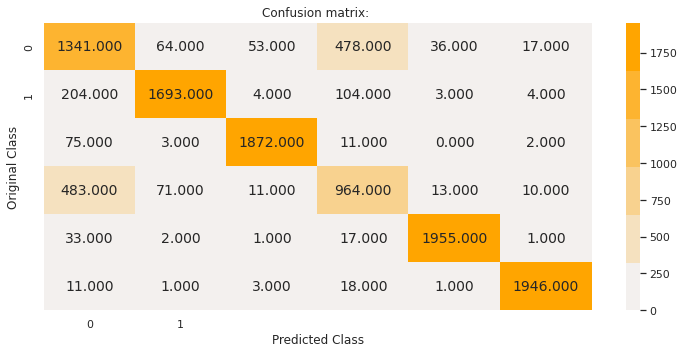

In [36]:
plot_cm_svm, df_metrics_svm = eval_models('svm', tuned_params_svm,
                                          tf_idf_train_features, y_train, 
                                          )
df_metrics_svm

Random Forest

In [ ]:
#init_clf = RandomForestClassifier()
#search_space = [
#{'n_estimators': [3, 10, 30, 50, 70, 100], 'max_features': ['sqrt','log2'],'min_samples_split': [5,10],'random_state': [42]}
#]
#tune_params(init_clf, search_space, tf_idf_train_features, y_train)

In [38]:
tuned_params_rf =[{'max_depth': 40, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'n_estimators': 10, 'random_state': 42}] 

In [41]:
df_metrics_rf = eval_models('rf', tuned_params_rf,
                                          tf_idf_train_features, y_train, "Random Forest"
                                          )
df_metrics_rf

(<Figure size 1944x1296 with 0 Axes>,
                accuracy_on_train  accuracy_on_test  cross_val_F1score  \
 Random Forest            0.76924          0.774098                NaN   
 
                F1-score  precision    recall  
 Random Forest  0.740767   0.816549  0.774098  )

<Figure size 1944x1296 with 0 Axes>

Boosting

AdaBoost

In [ ]:
#param_grid = {
              #'n_estimators':[10,50,250,1000],
              #'learning_rate':[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8]
             #}

In [ ]:
tuned_params_ada = [{'learning_rate': 0.8, 'n_estimators': 80, 'random_state': 42}]

In [ ]:
df_metrics_ada = eval_models('ada', tuned_params_ada,
                                          tf_idf_train_features, y_train,"Boosting"
                                         )
df_metrics_ada

XGBoost

In [ ]:
tuned_params_xgb = [{'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 4, 'min_child_weight': 2, 'n_estimators': 100, 'objective': 'binary:logistic', 'reg_alpha': 0, 'scale_pos_weight': 3, 'seed': 42, 'subsample': 0.8999999999999999}]

In [ ]:
df_metrics_xgb = eval_models('xgb', tuned_params_xgb,
                                          tf_idf_train_features, y_train,"Xgboost")

In [ ]:
df_metrics_xgb

In [ ]:
df_metrics_all = df_metrics_svm.append([df_metrics_rf,
                                       df_metrics_ada,
                                       df_metrics_xgb])
df_metrics_all